In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import uuid
import time
from typing import List

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.utils.validation import check_is_fitted
from statsmodels.tsa.stattools import adfuller
from IPython.display import Code, display
import inspect

import avh.utility_functions as utils
from avh.data_quality_issues import (
    IssueTransfomer,
    NumericIssueTransformer,
    CategoricalIssueTransformer,
    IncreasedNulls,
    SchemaChange,
    VolumeChange,
    DistributionChange,
    UnitChange,
    CasingChange,
    DQIssueDatasetTransformer,
)

from avh.data_generation import (
    DataColumn,
    NumericColumn,
    CategoricalColumn,
    NormalNumericColumn,
    UniformNumericColumn,
    StaticCategoricalColumn,
    RandomCategoricalColumn,
    DataGenerationPipeline,
)

from avh.metrics import (
    Metric,
    NumericMetric,
    CategoricalMetric,
    RowCount,
    DistinctCount,
    DistinctRatio,
    CompleteRatio,
    Mean,
    Median,
    Range,
    Min,
    Max,
    Sum,
    MeanDigitLength,
    MeanPunctuationLength,
    MeanStringLength,
)

from avh.constraints import (
    Constraint,
    ConstantConstraint,
    ChebyshevConstraint,
    CLTConstraint,
    ConjuctivDQProgram,
)

from avh.auto_validate_by_history import AVH

/var/folders/xt/wkwqs_m55g7gbq3p7p9zwdfw0000gq/T/ipykernel_6773/1648482314.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
import jupyter_black

jupyter_black.load()

# Auto-Validate-By-History (AVH) exploration & implementation

[Describe what AVH is - short intro]

## Table of Contents

* [Code](#Code)
    * [Helper functions](#Helper-functions)
    * [Definitions & Implementations](#Definitions-&-Implementations)
        * [Data Generation](#Data-Generation)
            * [Data Quality Issues](#Data-Quality-Issues)
            * [Data Pipeline Simulations](#Data-Pipeline-Simulations)
        * [Data Quality Metrics](#Data-Quality-Metrics)
        * [Constraints](#Data-Quality-Constraints)
        * [AVH Algorithm](#AVH-Algorithm)
    * [Simulations & Experiments](#Simulations-&-Experiments)
        * [FPR estimation methods]
            * [Chebyshev]
            * [Cantelli]
            * [CLT]
        * [AVH]
        * [Time series dereferencing] 

## Helper functions

Some helper functions that woul'd be put in some `utils` module.

In [4]:
def display_source_code(obj):
    """
    Renders the source code of obj
    """
    display(Code(inspect.getsource(obj), language="python"))
    print("")

In [5]:
display_source_code(utils.diff)

def diff(data: Iterable, period: int) -> np.array:
    """
    Perform difference of the elements separated by the period.
    (Useful for time series differencing)

    The resulting array is prepended with the np.nan
        to keep the shap of the original array
    """
    data = np.array(data)
    if period == 0:
        return data
    return np.concatenate((np.full(period, np.nan), data[period:] - data[:-period]))

In [6]:
display_source_code(utils.identity)
display_source_code(utils.safe_log)

@function_repr("identity")
def identity(x: Any) -> Any:
    """
    Identity function, returns the input
    """
    return x

@function_repr("log")
def safe_log(x: Union[Number, Iterable]) -> np.array:
    """
    Perform log(x), but with safeguards
        against cases where x == 0
    """
    data = np.array(x)
    log_data = np.log(
        data, out=np.zeros_like(data, dtype=np.float32), where=(data != 0)
    )

    if log_data.shape:
        return log_data
    return log_data.item()

## Definitions & Implementations

Provide a general summary of concepts from the paper (i.e. constraint, data quality metric)

The whole stuff is implemented as a framework that should be extensible.
Every topic has a "implementation" & "examples" sections, so you can only see the good parts

**Dictionary**:
* $DQ$ - data quality
* $C$ - column
* $H$ - column $C$ execution history: $H = \{C_1, C_2, ..., C_k\}$
* $M$ - $DQ$ metric, taken from a space $\boldsymbol{M}$, i.e. $M \in \boldsymbol{M}$
* $Q(M,C,\theta_l,\theta_u)$ - single-distribution $DQ$ constraint is defined using a statistical metric
$M \in \boldsymbol{M}$, over a target column of data $C$, with lower-bound threshold $\theta_l$ and upper bound $\theta_u$
* $Q(M,C,C',\theta_l,\theta_u)$ - two-distribution $DQ$ constraint is defined using a statistical metric
$M \in \boldsymbol{M}$, , that compares one batch “target” data in a column $C$, and a batch of “baseline” data $C'$, using threshold $\theta_l$ and  $\theta_u$
* $Q_i$ - a general notation of $DQ$ constraint on $C$. It makes up the constraint space $\boldsymbol{Q}$ on $C$, i.e. $\boldsymbol{Q} = \{Q_1, Q_2, ..., Q_i\}$ 
* $P(S)$ - conjunctive $DQ$ program. A combination of constraints $S$, $Q_i \in S$, where each $Q_i$ must hold for $C$ not to be flagged
* $D(C)$ - dataset of synthetically generated columns by injecting DQ issues into $C$
* $FPR(Q_i)$ - expected false positive rate of $Q_i$ when ran over $DQ$ issue free $C$ over time  
* $R(Q_i)$ - expected recall of $Q_i$: set of issues $Q_i$ can detect from $D(C)$


#### Data Generation

In the paper, the authors use a bunch of randomly selected columns $C$ from live-production data pipelines and trace them over a number of executions to form their histories $H$. They use this data to later conduct precision and recall testing.

In this notebook, however, we implement a simple data generation framework, which allows to simulate data pipelines' output. This setup, while clunky, allows you to define the columns making up the pipeline and inject desired $DQ$ issues to simulate various scenarious to test out $AVH$ robustness. Personally, it prooved incredibly useful for experimentation in early stages, and you can even play around by extending it to fit your desired needs.

#### Data Quality Issues

- [Implementation](#DQ-issue-implementation)  
- [Examples](#DQ-issue-examples)

The paper lists the most commond DQ issues found in literature in appendix B.  
Below we implement most of those DQ issues in the form of Sklearn transformers. Our chosen implementation and sklearn framework might not be the best combination, however, it was easier to develop by folwing an established architecture style guide.

##### DQ issue implementation

In [7]:
display_source_code(IssueTransfomer)
display_source_code(NumericIssueTransformer)
display_source_code(CategoricalIssueTransformer)

class IssueTransfomer(BaseEstimator, TransformerMixin):
    """
    Should work for every column

    Not necessarally efficiant
    """

    def __repr__(self):
        return f"{self.__class__.__name__}{str(self.get_params())}"

    def fit(self, df: pd.DataFrame, y=None, **kwargs):
        assert self._is_dataframe_compatable(df), f"{self.__class__.__name__} is not compatable with profided dataframe'"
        return self._fit(df, **kwargs)

    def _fit(self, df: pd.DataFrame, **kwargs):
        return self

    def transform(self, df: pd.DataFrame, y=None) -> pd.Series:
        #check_is_fitted(self)
        new_df = self._transform(df)
        return new_df.reset_index(drop=True)

    def _transform(self, df: pd.DataFrame) -> pd.Series:
        return df

    def _is_dataframe_compatable(self, df: pd.DataFrame) -> bool:
        return True

class NumericIssueTransformer(IssueTransfomer):
    def _is_dataframe_compatable(self, df: pd.DataFrame) -> bool:
        return len(self.numeric_columns_) > 0

    def fit(self, df: pd.DataFrame, y=None, **kwargs):
        self.numeric_columns_ = df.select_dtypes("number").columns
        assert self._is_dataframe_compatable(df), f"{self.__class__.__name__} is not compatable with profided dataframe"
        return self._fit(df, **kwargs)

class CategoricalIssueTransformer(IssueTransfomer):
    def _is_dataframe_compatable(self, df: pd.DataFrame) -> bool:
        return len(self.categorical_columns_) > 0

    def fit(self, df: pd.DataFrame, y=None, **kwargs):
        self.categorical_columns_ = df.select_dtypes(exclude="number").columns
        assert self._is_dataframe_compatable(df), f"{self.__class__.__name__} is not compatable with profided dataframe"
        return self._fit(df, **kwargs)

In [8]:
### General column issue transformers
display_source_code(IncreasedNulls)
display_source_code(SchemaChange)
display_source_code(VolumeChange)
display_source_code(DistributionChange)

class IncreasedNulls(IssueTransfomer):
    def __init__(self, p: float = 0.5):
        self.p = p

    def _transform(self, df: pd.DataFrame) -> pd.Series:
        new_df = df.copy()

        n = new_df.shape[0]
        sample_n = max(int(n * self.p), 1)
        indexes = np.random.choice(df.index, size=sample_n, replace=False)
        new_df.loc[indexes, :] = np.nan
        return new_df

class SchemaChange(IssueTransfomer):
    def __init__(self, p: float=0.5):
        self.p = p

    def _fit(self, df: pd.DataFrame, **kwargs):
        self.dtype_metadata_ = {
            dtype: df.select_dtypes(dtype).columns for dtype in df.dtypes.unique()
        }

        for dtype, columns in self.dtype_metadata_.items():
            assert (
                len(columns) > 1
            ), f"Column of dtype {dtype} does not have enough neighboars of the same type"

        return self

    def _transform(self, df: pd.DataFrame) -> pd.Series:
        new_df = df.copy()

        n = new_df.shape[0]
        sample_n = max(int(n * self.p), 1)
        indexes = np.random.choice(df.index, size=sample_n, replace=False)
        for dtype_columns in self.dtype_metadata_.values():
            for idx, column in enumerate(dtype_columns):
                next_column_name = dtype_columns[(idx + 1) % len(dtype_columns)]
                new_df.loc[indexes, column] = df.loc[indexes, next_column_name]

        return new_df

class VolumeChange(IssueTransfomer):
    def __init__(self, f: float = 2):
        """
        Performs random upsampling, downsampling
        If factor is > 1, then it's treated as a multiplyer for upsampling data volume
        If factor is < 1, then it's treated as a % of data to keep when downsampling
        """
        self.f = f

    def _transform(self, df: pd.DataFrame) -> pd.Series:
        n = df.shape[0]
        sample_n = max(int(n * self.f), 1)
        indexes = np.random.choice(
            df.index, sample_n, replace=True if self.f > 1 else False
        )

        return df.loc[indexes]

class DistributionChange(IssueTransfomer):
    def __init__(self, p: float = 0.1, take_last: bool = True):
        self.p = p
        self.take_last = take_last

    def _transform(self, df: pd.DataFrame) -> pd.Series:
        new_df = df.apply(lambda x: x.sort_values().values, axis=0)

        n = df.shape[0]
        sample_n = max(int(n * self.p), 1)
        sample_tile_count = math.ceil(n / sample_n)

        sample_idx = (
            new_df.index[-sample_n:] if self.take_last else new_df.index[:sample_n]
        )
        sample_idx = np.tile(sample_idx, sample_tile_count)[:n]
        return new_df.loc[sample_idx]

In [9]:
### Numerical column issue transformers
display_source_code(UnitChange)

class UnitChange(NumericIssueTransformer):
    def __init__(self, m: int = 2):
        self.m = m

    def _transform(self, df: pd.DataFrame) -> pd.Series:
        new_df = df.copy()
        new_df.loc[:, self.numeric_columns_] *= self.m
        return new_df

In [10]:
### Categorical column issue transformers
display_source_code(CasingChange)

class CasingChange(CategoricalIssueTransformer):
    def __init__(self, p: float = 0.5):
        self.p = p

    def _transform(self, df: pd.DataFrame) -> pd.Series:
        new_df = df.copy()

        n = new_df.shape[0]
        n_samples = max(int(n * self.p), 1)
        indexes = np.random.choice(new_df.index, size=n_samples, replace=False)

        new_df.loc[indexes, self.categorical_columns_] = new_df.loc[
            indexes, self.categorical_columns_
        ].apply(lambda x: x.str.swapcase(), axis=0)
        return new_df

fdkslfdlsflds issue dataset transformer

In [11]:
display_source_code(DQIssueDatasetTransformer)

class DQIssueDatasetTransformer(BaseEstimator, TransformerMixin):
    """
    Produces D(C) for declared issue transfomers
        and cartesian product of their parameters
    """

    def __init__(self, *issues):
        self.numeric_issues = []
        self.categorical_issues = []
        self.shared_issues = []
        for issue in issues:
            issue_class = issue[0]
            if issubclass(issue_class, NumericIssueTransformer):
                self.numeric_issues.append(issue)
            elif issubclass(issue_class, CategoricalIssueTransformer):
                self.categorical_issues.append(issue)
            else:
                self.shared_issues.append(issue)

    def fit(self, df: pd.DataFrame, y=None, **kwargs):
        self.columns_ = list(df.columns)
        self.numeric_columns_ = list(df.select_dtypes(include="number").columns)
        self.categorical_columns_ = list(set(self.columns_).difference(set(self.numeric_columns_)))
        return self

    def transform(self, df: pd.DataFrame, y=None):
        dataset = {column: [] for column in self.columns_}

        pbar = tqdm(desc="creating D(C)...")
        for dtype_issues, dtype_columns in self._iterate_by_dtype():
            if not dtype_columns:
                continue
                
            target_df = df[dtype_columns]
            for transformer, parameters in dtype_issues:
                fitted_transformer = transformer().fit(target_df)
                
                for param_comb in self._get_parameter_combination(parameters):
                    fitted_transformer.set_params(**param_comb)
                    fitted_transformer_signature = repr(fitted_transformer)
                    modified_df = fitted_transformer.transform(target_df)
                    
                    for column in dtype_columns:
                        dataset[column].append(
                            (fitted_transformer_signature, modified_df[column])
                        )
                    pbar.update(1)

        pbar.close()
        return dataset

    def _get_parameter_combination(self, params):
        for values in product(*params.values()):
            yield dict(zip(params.keys(), values))

    def _iterate_by_dtype(self):
        yield (self.shared_issues, self.columns_)
        yield (self.numeric_issues, self.numeric_columns_)
        yield (self.categorical_issues, self.categorical_columns_)

##### DQ issue examples

In [12]:
example_df = pd.DataFrame([1, 2, 3, 4, 5], columns=["example"])

transformed_df = UnitChange(3).fit_transform(example_df)

example_df["transformed_example"] = transformed_df["example"]
print(example_df)

   example  transformed_example
0        1                    3
1        2                    6
2        3                    9
3        4                   12
4        5                   15


Later on, we'll need to have $D(C)$ and `DQIssueDatasetTransformer` class will help us with that:

In [13]:
example_df = pd.DataFrame([1, 2, 3, 4, 5], columns=["example"])

issue_dataset_generator = DQIssueDatasetTransformer(
    (IncreasedNulls, {"p": [0.4, 0.8]}),
    (UnitChange, {"m": [2, 3]}),
    (DistributionChange, {"p": [0.4], "take_last": [True, False]}),
)

issue_dataset = issue_dataset_generator.fit_transform(example_df)
for issue_id, column in issue_dataset["example"]:
    print(issue_id)
    print(column)
    print("------------")

creating D(C)...: 6it [00:00, 444.54it/s]

IncreasedNulls{'p': 0.4}
0    1.0
1    2.0
2    NaN
3    NaN
4    5.0
Name: example, dtype: float64
------------
IncreasedNulls{'p': 0.8}
0    NaN
1    NaN
2    NaN
3    4.0
4    NaN
Name: example, dtype: float64
------------
DistributionChange{'p': 0.4, 'take_last': True}
0    4
1    5
2    4
3    5
4    4
Name: example, dtype: int64
------------
DistributionChange{'p': 0.4, 'take_last': False}
0    1
1    2
2    1
3    2
4    1
Name: example, dtype: int64
------------
UnitChange{'m': 2}
0     2
1     4
2     6
3     8
4    10
Name: example, dtype: int64
------------
UnitChange{'m': 3}
0     3
1     6
2     9
3    12
4    15
Name: example, dtype: int64
------------


#### Data Pipeline Simulations

- [Implementation](#Data-Pipeline-implementation)  
- [Examples](#Data-Pipeline-examples)

Bla bla bla

##### Data Pipeline implementation

In [14]:
display_source_code(DataColumn)

class DataColumn(ABC):
    """
    Abstract column class.
    Blueprint for generating data of specified type & behavior.

    Parameters
    ----------
    name: str
        The name of the column in the final output

    Attributes
    ----------
    name: str
        The name of the column in the final output
    dtype: Any
        The dtype of the column in the final output
    """

    def __init__(self, name: str):
        """
        If subclassed, the child should call the parent constructor
        """
        self._name = name

    @property
    def name(self) -> str:
        return self._name

    @abstractproperty
    def dtype(self) -> Any:
        ...

    @abstractmethod
    def generate(self, n: int, i: int = 0) -> pd.Series:
        """
        Output the generated Series of length n

        Parameters
        ----------
        n: int
            The length of the column to output
        i: int
            The i'th call of the column generation.
            Can be useful for modifying the genration parameters based on "time"
        """
        ...

In [15]:
display_source_code(NumericColumn)

class NumericColumn(DataColumn):
    """
    Abstract numeric column class.
    Blueprint for generating data for specifically numeric columns.

    Parameters
    ----------
    name: str
        The name of the column in the final output
    minimum: Optional[float]
        The minimum value this column should output
    maximum: Optional[float]
        The maximum value this column should ouptput
    dtype: Union[np.float32, np.int32]
        The dtype of this numeric column.
        Currently only accepts np.float32 or np.int32
    parameter_function: Optional[Callable]
        A function which accepts and returns the data generation parameters.
        Can be used to create "moving" columns, where column parameters are
            changed each call. If none, this function won't be applied
        The function must have the following definition:
            ```
            def func(n, i, *args):
                return *args
            ```
            Where:
            - 'n' is the column size during this generation call
            - 'i' is the iteration count (default is 0)
            - '*args' are the generaton parameters
    """

    def __init__(
        self,
        name: str,
        minimum: Optional[float] = -np.inf,
        maximum: Optional[float] = np.inf,
        dtype: Union[np.float32, np.int32] = np.float32,
        parameter_function: Optional[Callable] = None,
    ):
        """
        If subclassed, the child should call the parent constructor
        """
        super().__init__(name)
        assert (
            dtype == np.float32 or dtype == np.int32
        ), "Numeric column can only be of type np.float32 or np.int32"

        self._minimum = minimum
        self._maximum = maximum
        self._dtype = dtype
        self._parameter_function = parameter_function

    @property
    def dtype(self):
        return self._dtype

    @abstractmethod
    def _update_parameters(self, n: int, i: int) -> None:
        """
        Template method for applying the `parameter_function`
            to data generation parameters.

        Parameters
        ----------
        n: int
            The length of the column
        i: int
            The i'th call of the column generation.
        """
        ...

    @abstractmethod
    def _generate(self, n: int) -> np.array:
        """
        Template method for generating data.
        """
        ...

    def generate(self, n: int, i: int = 0) -> pd.Series:
        data = self._generate(n).astype(self.dtype)
        data = np.clip(data, self._minimum, self._maximum)

        if self._parameter_function:
            self._update_parameters(n, i)

        return pd.Series(
            data,
            name=self.name,
            dtype=self.dtype,
        )

In [16]:
display_source_code(UniformNumericColumn)
display_source_code(NormalNumericColumn)

class UniformNumericColumn(NumericColumn):
    """
    Concrete numeric column class.
    Generates data by using uniform PDF.

    Parameters
    ----------
    name: str
        The name of the column in the final output
    lower_bound: float
        Lower bound for unifrom PDF
    upper_bound: float
        Upper bound for uniform PDF
    **kwargs:
        Any other parameters will be forwarded back to parent classes
    """

    def __init__(self, name: str, lower_bound: float, upper_bound: float, **kwargs):
        super().__init__(name, **kwargs)
        self._lower_bound = lower_bound
        self._upper_bound = upper_bound

    def _generate(self, n: int) -> np.array:
        return np.random.uniform(self._lower_bound, self._upper_bound, n)

    def _update_parameters(self, n: int, i: int):
        self._lower_bound, self._upper_bound = self._parameter_function(
            n, i, self._lower_bound, self._upper_bound
        )

class NormalNumericColumn(NumericColumn):
    """
    Concrete numeric column class.
    Generates data by using normal PDF.

    Parameters
    ----------
    name: str
        The name of the column in the final output
    mean: float
        mean value used for normal PDF
    std: float
        standard deviation used for normal PDF
    **kwargs:
        Any other parameters will be forwarded back to parent classes
    """

    def __init__(self, name: str, mean: float, std: float, **kwargs):
        super().__init__(name, **kwargs)
        self._mean = mean
        self._std = std

    def _generate(self, n: int) -> np.array:
        return np.random.normal(self._mean, self._std, n)

    def _update_parameters(self, n: int, i: int):
        self._mean, self._std = self._parameter_function(n, i, self._mean, self._std)

In [17]:
display_source_code(CategoricalColumn)

class CategoricalColumn(DataColumn):
    """
    Abstract categorical/string column class.
    Blueprint for generating data for specifically string based columns.

    Note: this class uses the dtype of "object", since pandas Categorical dtype
        is specifically designed to protect against DQ issues, thus isn't flexible
        for our use case.

    Parameters
    ----------
    name: str
        The name of the column in the final output
    """

    def __init__(self, name: str):
        super().__init__(name)

    @property
    def dtype(self):
        return "object"

    @abstractmethod
    def _generate(self, n: int) -> np.array:
        """
        Template method for generating data.
        """
        ...

    def generate(self, n: int, *args, **kwargs) -> pd.Series:
        data = self._generate(n)
        return pd.Series(
            data,
            name=self.name,
            dtype=self.dtype,
        )

In [18]:
display_source_code(StaticCategoricalColumn)
display_source_code(RandomCategoricalColumn)

class StaticCategoricalColumn(CategoricalColumn):
    """
    Concrete categorical column class.
    Outputs the column populated by provided values.

    Parameters
    ----------
    name: str
        The name of the column in the final output
    values: List[str]
        A list of values which the column will output.
        The list of values must be equal in length to requested column size.
    **kwargs:
        Any other parameters will be forwarded back to parent classes
    """

    def __init__(self, name: str, values: List[str], **kwargs):
        super().__init__(name, **kwargs)
        self._values = values

    def _generate(self, n: int) -> np.array:
        assert n == len(self._values), (
            f"The StaticCategoricalColumn does not have equal number of values "
            f"to fill a column of size {n}"
        )
        return np.array(self._values)

class RandomCategoricalColumn(CategoricalColumn):
    """
    Concrete categorical column class.
    Outputs the column randomly populated by a pool of values.

    Parameters
    ----------
    name: str
        The name of the column in the final output
    values: Optional[List[str]]
        A list of values which will be used to randomly populate the column.
        If None, the class will output random lorem sentences.
    **kwargs:
        Any other parameters will be forwarded back to parent classes
    """

    def __init__(self, name: str, values: Optional[List[str]] = None, **kwargs):
        super().__init__(name, **kwargs)
        self._values = values

    def _generate(self, n: int) -> np.array:
        if self._values:
            return np.random.choice(self._values, n)
        else:
            random_idx = np.random.randint(0, len(raw_book) - 20, n)
            return np.array(
                [raw_book[random_idx[i] : random_idx[i] + 20] for i in range(n)]
            )

In [19]:
display_source_code(DataGenerationPipeline)

class DataGenerationPipeline:
    """
    Combine multiple DataColumn and IssueTransfomer instances
    to produce a pipeline output.

    The applying of DQ issues follow these rules:
        * The issues are applyed in the order they are defined in the parameter
        * Each issue transformer is fed the original output of the columns
            and not the modified versions of them by the previous transformers.
            This is done, to make the effects of issues more independant.
        * The issues are expected to be defined fully for each column.
            That means repeated definitions for the same column will be overriden.
            An exception to this is when 'all' columns are used, since after each
            issue used to modify 'all' column, the output dataframe replaces the
            original reference dataframe. This is done so you could use issues
            for 'all' and specific columns together, without overriding each other.

    Parameters
    ----------
    columns: List[DataColumn]
        A list of DataColumn instances which define the columns of final dataframe.
    issues: List[Tuple[str, List[IssueTransfomer]]]
        A list of tuples defining the issues to inject into a column.
        Each tuple contains:
            * column: str
                The column name to which apply the following data issues
                Use 'all' to inject the issues into all columns.
            * issue_transformers: List[IssueTransfomer]
                A list of IssueTransfomer to apply to the column above
    """

    def __init__(
        self,
        columns: List[DataColumn],
        issues: List[Tuple[str, List[IssueTransfomer]]] = [],
    ):
        self._columns = columns
        self.issues = issues
        self.iteration = 1

    def generate(self, n: int) -> pd.DataFrame():
        """
        Combines the outputs of each specified DataColumn into a dataframe
            of length n
        """
        data = pd.concat(
            [column.generate(n, self.iteration) for column in self._columns], axis=1
        )
        data = self._apply_issues(data)
        self.iteration += 1
        return data

    def generate_uniform(self, lower: int, higher: int) -> pd.DataFrame():
        """
        Combines the outputs of each specified DataColumn into a dataframe
            of variable length, randomly picked from uniform PDF
        """
        return self.generate(max(1, np.random.randint(lower, higher)))

    def generate_normal(self, mean: int, std: int) -> pd.DataFrame():
        """
        Combines the outputs of each specified DataColumn into a dataframe
            of variable length, randomly picked from normal PDF
        """
        return self.generate(max(1, int(np.random.normal(mean, std))))

    def _apply_issues(self, data: pd.DataFrame) -> pd.DataFrame:
        for col, issues in self.issues:
            for issue in issues:
                if col == "all":
                    data = issue.fit_transform(data)
                else:
                    column_dtype = data[col].dtype
                    dtype_columns = data.select_dtypes(column_dtype).columns
                    transformed_column = issue.fit_transform(data[dtype_columns])[col]
                    data = pd.concat(
                        [data.drop(col, axis=1), transformed_column], axis=1
                    )

        return data

##### Data Pipeline examples

Using `DataGenerationPipeline` is rather simple, you just pass it a list of `DataColumn` objects into the `columns` paramter and start generating data with the `generate()` method!

In [20]:
pipeline = DataGenerationPipeline(
    columns=[
        NormalNumericColumn("money", 300, 10),
        UniformNumericColumn("friends", 10, 20, dtype=np.int32),
        RandomCategoricalColumn("pets", ["Dogs", "cats", "Birds"]),
        RandomCategoricalColumn("random_text"),
    ],
)

print(pipeline.generate(5))

        money  friends  pets           random_text
0  294.997192       19  Dogs  scipline than in mer
1  315.796387       15  cats  nsparent, brittle, o
2  297.328796       12  Dogs  re inscribed, and so
3  305.226013       15  cats  e the Pequod tovisit
4  304.119171       13  cats  And whenafter gainin


Of course, you can generate a variable-length executions so your $H$ woudn't have the same length $C$'s every time!  
Just use `generate_uniform()` or `generate_normal()` methods:

In [21]:
sequential_executions_uniform = [
    len(pipeline.generate_uniform(10, 100)) for i in range(10)
]
print("Unifrom(10, 100) generation execution lengths: ", sequential_executions_uniform)

sequential_executions_normal = [
    len(pipeline.generate_normal(100, 10)) for i in range(10)
]

print("Normal(100, 10) generation execution lengths: ", sequential_executions_normal)

Unifrom(10, 100) generation execution lengths:  [83, 95, 99, 79, 29, 25, 10, 25, 38, 80]
Normal(100, 10) generation execution lengths:  [109, 100, 110, 108, 102, 93, 111, 106, 102, 118]


You can define some more interesting numeric columns by adding a function to their data generating parameters!  
Simply pass a function to the `parameter_function` parameter of the `NumericColumn` that accepts and returns data generation paramters. This function must also accept column size `n` and iteration `i` parameters! 

In this example we create a moving column, which simulates doubling revenue values every execution, due to growing market:

In [22]:
pipeline = DataGenerationPipeline(
    columns=[
        NormalNumericColumn(
            "money", 100, 10, parameter_function=lambda n, i, mean, std: (mean * 2, std)
        ),
    ],
)

sequential_execution_df = pd.DataFrame(
    {
        "t1": pipeline.generate(5)["money"],
        "t2": pipeline.generate(5)["money"],
        "t3": pipeline.generate(5)["money"],
    }
)
print(sequential_execution_df)

           t1          t2          t3
0   79.505623  194.280746  405.768311
1  102.818977  206.834641  393.299347
2  109.170738  197.512390  382.350708
3  107.576813  205.488785  398.152344
4   92.992485  185.983475  393.900635


You can also inject $DQ$ issue transformers defined previously, to generate columns with $DQ$ already present!  
You just need to pass a list of tuples into a separate `issues` parameter, where each tuple contains the name of the column to which apply the issues and a list of issue transformers that should be applied:

In [23]:
pipeline = DataGenerationPipeline(
    columns=[
        NormalNumericColumn("money", 300, 10),
        RandomCategoricalColumn("pets", ["dogs", "cats", "birds"]),
        RandomCategoricalColumn("names", ["Martynas", "Justas", "Jokubas"]),
    ],
    issues=[
        ("pets", [SchemaChange(0.5), CasingChange(0.5)]),
        ("all", [IncreasedNulls(0.2)]),
    ],
)

print(pipeline.generate(6))

        money     names      pets
0  299.061035  Martynas      dogs
1         NaN       NaN       NaN
2  295.079254   Jokubas      CATS
3  307.723816    Justas    Justas
4  296.520996    Justas    jUSTAS
5  301.779266  Martynas  mARTYNAS


#### Data Quality Metrics

- [Implementation](#DQ-metric-implementation)  
- [Examples](#DQ-metric-examples)

Bla bla bla

fjklds  fjldsjf dsf flsjslfds 

##### DQ metric implementation

In [24]:
display_source_code(Metric)
display_source_code(NumericMetric)
display_source_code(CategoricalMetric)

class Metric(ABC):
    """
    Metric is a static utility class
    """

    @classmethod
    def is_column_compatable(self, dtype: Any) -> bool:
        return True

    @classmethod
    def calculate(
        self, data: Union[pd.Series, List[pd.Series]]
    ) -> Union[float, List[float]]:
        """
        Method for calculating the target metric from given data
        """
        if isinstance(data, list):
            return list(map(self._calculate, data))
        return self._calculate(data)

    @classmethod
    @abstractmethod
    def _calculate(self, data: pd.Series) -> float:
        ...

    @classmethod
    def _is_empty(self, data: pd.Series) -> bool:
        if data.count() == 0:
            return True
        return False

class NumericMetric(Metric):
    @classmethod
    def is_column_compatable(self, dtype: Any) -> bool:
        return pd.api.types.is_numeric_dtype(dtype)

class CategoricalMetric(Metric):
    @classmethod
    def is_column_compatable(self, dtype: Any) -> bool:
        return not pd.api.types.is_numeric_dtype(dtype)

In [25]:
display_source_code(RowCount)
display_source_code(DistinctRatio)
display_source_code(CompleteRatio)

class RowCount(Metric):
    @classmethod
    def _calculate(self, column: pd.Series) -> float:
        return len(column)

class DistinctRatio(Metric):
    """
    I don't like that this is also a numeric metric!
    Since it's almost always treated as a statistical invariate
    because yeah, floating point numbers will mostly be unique all the time!!!
    """

    @classmethod
    def _calculate(self, column: pd.Series) -> float:
        return column.nunique(dropna=False) / len(column)

class CompleteRatio(Metric):
    @classmethod
    def _calculate(self, column: pd.Series) -> float:
        if column.empty:
            return 0.0
        return column.count() / column.size

In [26]:
display_source_code(Min)
display_source_code(Max)
display_source_code(Mean)
display_source_code(Median)
display_source_code(Sum)
display_source_code(Range)

class Min(NumericMetric):
    @classmethod
    def _calculate(self, column: pd.Series) -> float:
        if self._is_empty(column):
            return 0.0
        return column.min()

class Max(NumericMetric):
    @classmethod
    def _calculate(self, column: pd.Series) -> float:
        if self._is_empty(column):
            return 0.0
        return column.max()

class Mean(NumericMetric):
    @classmethod
    def _calculate(self, column: pd.Series) -> float:
        if self._is_empty(column):
            return 0.0
        return column.mean()

class Median(NumericMetric):
    @classmethod
    def _calculate(self, column: pd.Series) -> float:
        if self._is_empty(column):
            return 0.0
        return np.nanmedian(column)

class Sum(NumericMetric):
    @classmethod
    def _calculate(self, column: pd.Series) -> float:
        if self._is_empty(column):
            return 0.0
        return column.sum()

class Range(NumericMetric):
    @classmethod
    def _calculate(self, column: pd.Series) -> float:
        if self._is_empty(column):
            return 0.0
        return np.max(column) - np.min(column)

In [27]:
display_source_code(DistinctCount)
display_source_code(MeanStringLength)
display_source_code(MeanDigitLength)
display_source_code(MeanPunctuationLength)

class DistinctCount(CategoricalMetric):
    @classmethod
    def _calculate(self, column: pd.Series) -> float:
        return column.nunique(dropna=False)

class MeanStringLength(CategoricalMetric):
    @classmethod
    def _calculate(self, column: pd.Series) -> float:
        if self._is_empty(column):
            return 0.0
        return np.nanmean(column.str.len())

class MeanDigitLength(CategoricalMetric):
    @classmethod
    def _calculate(self, column: pd.Series) -> float:
        if self._is_empty(column):
            return 0.0
        return np.nanmean(column.str.count(r"\d"))

class MeanPunctuationLength(CategoricalMetric):
    @classmethod
    def _calculate(self, column: pd.Series) -> float:
        if self._is_empty(column):
            return 0.0
        return np.nanmean(column.str.count(r"[!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~]"))

##### DQ metric examples

Since `Metric` based classes are static, you don't need to instantiate them and can simply use them by passing the `pd.Series` object into their `calculate()` method:

In [28]:
values = pd.Series([1, 2, np.nan, 3, np.nan, np.nan])

print(f"The array contains {CompleteRatio.calculate(values) * 100}% non-null values!")

The array contains 50.0% non-null values!


The metrics do have a `is_column_compatable()` method, to determine if the column $C$ can be used together with the target metric.  
This was done to make downstream constraint $Q$ generation easier as to not keep tabs on what $C$ & $M$ are compatable manually.

In [29]:
string_column = pd.Series(["hello", "how", "are", "you?"])

print(Mean.is_column_compatable(string_column))

False


#### Data Quality Constraints

- [Implementation](#DQ-constraint-implementation)  
- [Examples](#DQ-constraint-examples)

In our & original papers' implementation, $\beta$ is used as the offset from the mean of $H$ distribution, thus defining the $M$ interval upon which $Q$ operates. The different classes just implement different expected FPR estimation methods.

##### DQ constraint implementation

In [30]:
display_source_code(Constraint)

class Constraint(BaseEstimator):
    """
    Constraint Predictor entity class.
    It acts as a general abtraction for doing inference with Metric.

    The Constraint entity needs to have the following attributes:
        * compatable_metrics - a tuple of compatable metric classes.
            By default, all (sub)classes of type Metric are compatable.
        * u_upper_ - threshold for triggering the constraint if Metric goes above it
        * u_lower_ - threshold for triggering the constraint if Metric goes below it
        * expected_fpr - expected false positive rate once constraint is fitted.
        * metric_history_ - H(C) = {M(C1), M(C2), ..., M(C3)}

    The Constraint entity needs to have the following methods:
        * fit - prepare the constraint for inference.
        * predict - given a value, check if it violates the constraint.
    """

    # TODO: find a better way to do this without hardcoding solid class names
    compatable_metrics = (metrics.Metric,)

    def __init__(
        self,
        metric: metrics.Metric,
        differencing_lag: int = 0,
        preprocessing_func: Callable = utils.identity,
    ):
        self.metric = metric
        self.differencing_lag = differencing_lag
        self.preprocessing_func = preprocessing_func

    @classmethod
    def is_metric_compatable(self, metric: metrics.Metric):
        return issubclass(metric, self.compatable_metrics)

    def _get_metric_repr(self):
        metric_repr = self.metric.__name__
        preprocessng_func_repr = self.preprocessing_func.__function_repr__
        if preprocessng_func_repr != "identity":
            metric_repr = "{}({})".format(preprocessng_func_repr, metric_repr)
        if self.differencing_lag != 0:
            metric_repr = "{}.diff({})".format(metric_repr, self.differencing_lag)
        return metric_repr

    def __repr__(self):
        metric_repr = self._get_metric_repr()
        return "{name}({u_lower:0.4f} <= {metric} <= {u_upper:0.4f}, FPR = {fpr:0.4f})".format(
            name=self.__class__.__name__,
            u_lower=self.u_lower_,
            metric=metric_repr,
            u_upper=self.u_upper_,
            fpr=self.expected_fpr_,
        )

    def fit(
        self,
        column_history,
        y=None,
        hotload_history: bool = False,
        preprocessed_metric_history: np.array = None,
        **kwargs,
    ) -> None:
        assert self.is_metric_compatable(self.metric), (
            f"The {self.metric.__name__} is not compatible with "
            f"{self.__class__.__name__}"
        )

        self.metric_history_raw_ = (
            column_history if hotload_history else self.metric.calculate(column_history)
        )
        self.metric_history_post_ = (
            preprocessed_metric_history
            if preprocessed_metric_history
            else self._preprocess(self.metric_history_raw_, inference=False)
        )

        self._fit(self.metric_history_post_, **kwargs)
        return self

    def predict(self, column: pd.Series, **kwargs) -> bool:
        check_is_fitted(self)

        metric_raw = self.metric.calculate(column)
        metric_post = self._preprocess(metric_raw)

        prediction = self._predict(metric_post, **kwargs)
        self.metric_history_raw_.append(metric_raw)
        self.metric_history_post_.append(metric_post)
        return prediction

    def _fit(self, metric_history: List[float], **kwargs):
        self.u_lower_ = 0.0
        self.u_upper_ = 1.0
        self.expected_fpr_ = 1.0
        return self

    def _predict(self, m: float, **kwargs) -> bool:
        return self.u_lower_ <= m <= self.u_upper_

    def _preprocess(
        self, data: Union[List[float], float], inference=True
    ) -> Union[List[float], float]:
        data = self.preprocessing_func(data)

        if self.differencing_lag != 0:
            if inference:
                data = data - self.preprocessing_func(
                    self.metric_history_raw_[-self.differencin

In [31]:
display_source_code(ConstantConstraint)
display_source_code(ChebyshevConstraint)
display_source_code(CLTConstraint)

class ConstantConstraint(Constraint):
    """
    Concrete Constraint subclass,
        which operates on manually provided threshold values
    """

    def __init__(self, metric: metrics.Metric, u_lower: float, u_upper: float, expected_fpr):
        super().__init__(metric)

        # technically not following the sklearn style guide :(
        self.u_upper_ = u_upper
        self.u_lower_ = u_lower
        self.expected_fpr_ = expected_fpr

class ChebyshevConstraint(Constraint):
    """
    Chebyshev!
    """

    def _fit(self, metric_history: List[float], beta: float):
        mean = np.nanmean(metric_history)
        var = np.nanvar(metric_history)

        self.u_upper_ = mean + beta
        self.u_lower_ = mean - beta

        if var == 0:
            self.expected_fpr_ = 0.0
        else:
            self.expected_fpr_ = var / (beta**2)

class CLTConstraint(Constraint):
    compatable_metrics = (
        metrics.RowCount,
        metrics.Mean,
        metrics.MeanStringLength,
        metrics.MeanDigitLength,
        metrics.MeanPunctuationLength,
        metrics.CompleteRatio,
    )

    def _bell_function(sefl, x):
        return math.pow(math.e, -(x**2))

    def _fit(self, metric_history: List[float], beta: float):
        mean = np.nanmean(metric_history)
        std = np.nanstd(metric_history)

        self.u_upper_ = mean + beta
        self.u_lower_ = mean - beta

        if std == 0:
            self.expected_fpr_ = 0.0
        else:
            satisfaction_p = (2 / np.sqrt(math.pi)) * (
                integrate.quad(self._bell_function, 0, beta / (np.sqrt(2) * std))[0]
            )
            self.expected_fpr_ = 1 - satisfaction_p

##### DQ constraint examples

To begin with, let's define our data! We'll create a simple column named "money", which is generated from a Normal PDF with a mean of `300` and std of `10`. We'll collect a 100 executions of that column as history $H$ and another one as the "new" execution $C$.

In [32]:
# Defining H and C
pipeline = DataGenerationPipeline(
    columns=[
        NormalNumericColumn("money", 300, 10),
    ],
)

column_history = [pipeline.generate(100).squeeze() for i in range(100)]
new_execution = pipeline.generate(100).squeeze()

Now, creating the constraint Q with `Constraint` based classes is really simple!  

First, you create the $Q$ object by passing the desired metric $M$ into the constructor!  

In [33]:
constraint = ChebyshevConstraint(Range)

Secondly, fit the $Q$ by passing the column history $H$ together with offset $\beta$ to the `fit()` method.  

Note: in order to save some computation in further algorithms, we have also implemented the posibility to pass both precomputed and preprocessed metric histories to the `fit()` function so as to not do it twice. The related arguments are:
* `hotload_history: bool` - if True, then the `column_history` is interpreted as an already computed metric history and not a list of column executions. Important! The passed metric history should be "raw" metric history i.e. `metric.calculate(column_hist)` and not some form of preprocessed form of it, since it's important for the constraint to have the original column metric history for time differencing reasons.
  
* `preprocessed_metric_history: np.array` - if passed, this will be used by the constraint as the "preprocessed" metric history rather than computing it itself from the `column_history`. Again, this is mainly to save computation when we already have precomputed metrics.

In [34]:
constraint = constraint.fit(column_history, beta=20.0)

Lastly, given a new column $C$ execution, pass it to `predict()` to see if the $Q$ holds or is violated. 

In [35]:
print("New execution range: ", Range.calculate(new_execution))
if constraint.predict(new_execution):
    print("Constraint is not violated!")
else:
    print("Constraint is violated!")

New execution range:  44.197235
Constraint is not violated!


Once, fitted, the `Constraint` classes expose these 3 main attributes: `u_lower_`, `u_upper_`, `expected_fpr_` which will indicate the $M$ boundary of the $Q$ and the expected $FPR$ it produces. However, you can simply print the $Q$ for a helpful summary string!

In [36]:
constraint

ChebyshevConstraint(29.7086 <= Range <= 69.7086, FPR = 0.0878)

Finally, as explained in the paper, some FPR bound estimation methods can only be used with certain types of metrics, so all `Constraint` based classes have a static `is_metric_compatable()` method, to determine if that particular constraint can be used with a desired metric!

In [37]:
print(ChebyshevConstraint.is_metric_compatable(DistinctCount))
print(CLTConstraint.is_metric_compatable(DistinctCount))

True
False


#### AVH Algorithm

- [Implementation](#AVH-implementation)  
- [Examples](#AVH-examples)

In our & original papers' implementation, $\beta$ is used as the offset from the mean of $H$ distribution, thus defining the $M$ interval upon which $Q$ operates. The different classes just implement different expected FPR estimation methods.

##### AVH implementation

In [38]:
display_source_code(ConjuctivDQProgram)

class ConjuctivDQProgram:
    def __init__(
        self,
        constraints: Optional[List[Constraint]] = None,
        recall: Optional[Set[str]] = None,
        contributions: Optional[List[Set[str]]] = None,
    ):
        self.constraints = constraints if constraints else []
        self.recall = recall if recall else set({})
        self.contributions = contributions if contributions else []

    def __repr__(self):
        return "{constraints}, FPR = {fpr:4f}".format(
            constraints="\n".join([repr(q) for q in self.constraints]),
            fpr=self.expected_fpr,
        )

    @property
    def expected_fpr(self):
        return sum([q.expected_fpr_ for q in self.constraints])

    # def fit()

    def predict(self, column: pd.Series, **kwargs):
        for constraint in self.constraints:
            if not constraint.predict(column, **kwargs):
                return False
        return True

In [39]:
# program = ConjuctivDQProgram(
#     constraints = [
#         StaticConstraint(),
#         ChebyshevConstraint()
#     ]
# )

# program.fit(column)
# program.predict()

In [40]:
# import importlib
# import auto_validate_by_history

# importlib.reload(auto_validate_by_history)
# from auto_validate_by_history import AVH

In [41]:
display_source_code(AVH)

class AVH:
    """
    Returns a dictionary with ConjuctivDQProgram for a column
    """

    def __init__(
        self,
        M: List[Metric],
        E: List[Constraint],
        DC: Optional[DQIssueDatasetTransformer] = None,
        columns: Optional[List[str]] = None,
        time_differencing: bool = False,
    ):
        self.M = M
        self.E = E
        self.columns = columns
        self.time_differencing = time_differencing

        self.issue_dataset_generator = (
            DC if DC else self._get_default_issue_transformer()
        )

    def generate(
        self, history: List[pd.DataFrame], fpr_target: float, multiprocess=False
    ) -> Dict[str, ConjuctivDQProgram]:
        PS = {}

        DC = self.issue_dataset_generator.fit_transform(history[-1])
        columns = self.columns if self.columns else list(history[0].columns)

        for column in tqdm(columns, "Generating P(S for columns..."):
            start = time.time()
            Q = self._generate_constraint_space(
                [run[column] for run in history[:-1]]
            )
            end = time.time()
            print(f"Q generation took: {end-start}")

            start = time.time()
            PS[column] = self._generate_conjuctive_dq_program(
                Q, DC[column], fpr_target
            )
            end = time.time()
            print(f"PS generation took: {end-start}")

        return PS

    def generate_batched(
        self, history: List[pd.DataFrame], fpr_target: float
    ) -> Dict[str, ConjuctivDQProgram]:
        PS = {}

        DC = self.issue_dataset_generator.fit_transform(history[-1])
        columns = self.columns if self.columns else list(history[0].columns)

        Q = {}
        start = time.time()
        for column in tqdm(columns, "Generating Q for columns..."):
            q = self._generate_constraint_space([run[column] for run in history[:-1]])
            Q[column] = q
        end = time.time()
        print(f"Q generation took: {end-start}")

        start = time.time()
        for column in tqdm(columns, "Generating P(S) for columns..."):
            PS[column] = self._generate_conjuctive_dq_program(
                Q[column], DC[column], fpr_target
            )
        end = time.time()
        print(f"PS generation took: {end-start}")

        return PS

    def generate_batched_threaded(
        self, history: List[pd.DataFrame], fpr_target: float
    ) -> Dict[str, ConjuctivDQProgram]:
        PS = {}

        DC = self.issue_dataset_generator.fit_transform(history[-1])
        columns = self.columns if self.columns else list(history[0].columns)

        Q = {}
        start = time.time()
        with ThreadPoolExecutor() as executor:
            futures = [
                executor.submit(
                    self._generate_constraint_space,
                    [run[column] for run in history[:-1]]
                )
                for column in columns
            ]
            
            for result in tqdm(as_completed(futures), "Generating Q for columns...", total=len(columns)):
                _ = result.result()
                
        end = time.time()
        print(f"Q generation took: {end-start}")

        # start = time.time()
        # for column in tqdm(columns, "Generating P(S) for columns..."):
        #     PS[column] = self._generate_conjuctive_dq_program(
        #         Q[column], DC[column], fpr_target
        #     )
        # end = time.time()
        # print(f"PS generation took: {end-start}")

        return PS

    def generate_batched_parallel(
        self, history: List[pd.DataFrame], fpr_target: float
    ) -> Dict[str, ConjuctivDQProgram]:
        PS = {}

        DC = self.issue_dataset_generator.fit_transform(history[-1])
        columns = self.columns if self.columns else list(history[0].columns)

        Q = {}
        start = time.time()
        arguments = ((column, [run[column] for run in history[:-1]]) for column in columns)
        with mp.P

##### AVH examples

To use the `AVH` class, you need to have several things beforehand:  
1.) A metric space $M$  
2.) Constraint estimator space $E$  
3.) Pipeline execution history $H$ and new batch $C$  
4.) DQ issue dataset $D(C)$ for a desired column (AVH does have a default one)  
5.) FPR target for a $P(S)$  

The example below shows how to set up each part of the puzzle:

In [42]:
# Defining M space
M = [
    RowCount,
    DistinctRatio,
    DistinctCount,
    CompleteRatio,
    Min,
    Max,
    Mean,
    Median,
    Sum,
    Range,
    MeanStringLength,
    MeanDigitLength,
    MeanPunctuationLength,
]

# Defining available constraint estimators
# Note: Order not important as Q space will be constructed
#     from cartesian product of E & M
E = [CLTConstraint, ChebyshevConstraint]

# Defining C and H
pipeline = DataGenerationPipeline(
    columns=[
        NormalNumericColumn("money", 300, 10),
        NormalNumericColumn("age", 18, 2),
        RandomCategoricalColumn("pets", ["dog", "cat", "snail"]),
        RandomCategoricalColumn("text"),
    ],
    issues=[
        ("money", [IncreasedNulls(0.01)]),
    ],
)

H = [pipeline.generate_normal(1000, 30) for i in range(31)]

# Optionally defining a custom D(C) generator
# (AVH does construct a default one from a paper!)
custom_issue_dataset_generator = DQIssueDatasetTransformer(
    (IncreasedNulls, {"p": [0.1, 0.5, 1.0]}),
    (UnitChange, {"m": [2, 3, 10]}),
    (DistributionChange, {"p": [0.1, 0.5, 1.0], "take_last": [True, False]}),
)

Having defined all the needed prerequisites, we can finally create our automatic $P(S)$ with `AVH` class!  
All you need to do is to provide $M$, $E$, column list (or empty list for all columns), and (optionally) $D(C)$ into the constructor and call `generate` method with $H$, and $FPR$ target to get automatically defined $P(S)$

In [48]:
# %%time
history = [run["money"] for run in H]
avh = AVH(M, E, columns=["money"])
DC = avh._get_default_issue_transformer().fit_transform(H[-1])["money"]

Q = AVH(M, E, columns=["money"])._generate_constraint_space(history)

creating D(C)...: 20it [00:00, 330.48it/s]


In [49]:
%%time

for q in Q:
    start = time.time()
    for issue, data in DC:
        _ = q.predict(data)
    end = time.time()
    print(f"{q} took {(end-start) * 1000} ms...")

CLTConstraint(976.4363 <= RowCount <= 1031.1766, FPR = 0.3173) took 0.1857280731201172 ms...
CLTConstraint(967.3129 <= RowCount <= 1040.3000, FPR = 0.1824) took 0.16617774963378906 ms...
CLTConstraint(958.1896 <= RowCount <= 1049.4233, FPR = 0.0956) took 0.1289844512939453 ms...
CLTConstraint(949.0662 <= RowCount <= 1058.5467, FPR = 0.0455) took 0.12111663818359375 ms...
CLTConstraint(939.9428 <= RowCount <= 1067.6701, FPR = 0.0196) took 0.12493133544921875 ms...
CLTConstraint(930.8194 <= RowCount <= 1076.7935, FPR = 0.0077) took 0.12278556823730469 ms...
CLTConstraint(921.6961 <= RowCount <= 1085.9168, FPR = 0.0027) took 0.1361370086669922 ms...
CLTConstraint(912.5727 <= RowCount <= 1095.0402, FPR = 0.0009) took 0.2548694610595703 ms...
CLTConstraint(903.4493 <= RowCount <= 1104.1636, FPR = 0.0002) took 0.14901161193847656 ms...
CLTConstraint(894.3259 <= RowCount <= 1113.2870, FPR = 0.0001) took 0.12612342834472656 ms...
ChebyshevConstraint(866.9558 <= RowCount <= 1140.6571, FPR = 0.0

In [57]:
pipeline_ps = AVH(M, E, columns=["money"]).generate(H, fpr_target=0.4)
pipeline_ps["money"]

creating D(C)...: 20it [00:00, 272.90it/s]
Generating P(S for columns...: 100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  6.58it/s]

Q generation took: 0.04854083061218262
recall calculations took: 0.1022939682006836
Singleton finding took: 6.508827209472656e-05
Main loop took: 0.00013589859008789062
PS generation took: 0.10254621505737305


CLTConstraint(975.5406 <= RowCount <= 1030.1928, FPR = 0.3173), FPR = 0.317311

The `AVH.generate()` returns dictionary, holding `ConjuctivDQProgram` object for each specified column. `ConjuctivDQProgram` is simply a wrapper for multiple $Q$'s and thus possesess the same `predict()` method for iterating every constraint inside it.  
Besides that, `ConjuctivDQProgram` also contains such attributes:
- constraints: list of $Q$
- recall: set of $DQ$ issue id's from $D(C)$ which this $P(S)$ covers
- contributions: list of recalls for each constraint (i.e. individual recall contributions)
- expected_fpr: sum of all the constraint expected $FPR$'s

*P.S. name 'wrapper' in our context is no way related to the 'adapter' programming design pattern*

In [58]:
def explain_ps(ps: ConjuctivDQProgram):
    print("This P(S) has expected FPR of:")
    print(ps.expected_fpr)
    print("-" * 10)

    print("Constraints making up the conjunctive DQ program:")
    print(ps)
    print("-" * 10)

    print(f"This P(S) caught {len(ps.recall)} issues!")
    print("DQ issues that this DQ program covers from D(C):")
    for caught_issue in ps.recall:
        print(caught_issue)
    print("-" * 10)

    print("Individual recall contributions from all P(S) constraints:")
    for constraint, recall in zip(ps.constraints, ps.contributions):
        print("*" * 10)
        print(f"Constraint {str(constraint)} covers:")
        for issue in recall:
            print(issue)


ps = pipeline_ps["money"]
explain_ps(ps)

This P(S) has expected FPR of:
0.3173105078629139
----------
Constraints making up the conjunctive DQ program:
CLTConstraint(975.5406 <= RowCount <= 1030.1928, FPR = 0.3173), FPR = 0.317311
----------
This P(S) caught 17 issues!
DQ issues that this DQ program covers from D(C):
VolumeChange{'f': 0.5}
DistributionChange{'p': 0.1, 'take_last': False}
DistributionChange{'p': 0.5, 'take_last': False}
IncreasedNulls{'p': 1.0}
VolumeChange{'f': 2.0}
IncreasedNulls{'p': 0.5}
VolumeChange{'f': 10.0}
VolumeChange{'f': 0.1}
UnitChange{'m': 1000}
SchemaChange{'p': 0.5}
IncreasedNulls{'p': 0.1}
DistributionChange{'p': 0.5, 'take_last': True}
DistributionChange{'p': 0.1, 'take_last': True}
UnitChange{'m': 10}
UnitChange{'m': 100}
SchemaChange{'p': 0.1}
SchemaChange{'p': 1.0}
----------
Individual recall contributions from all P(S) constraints:
**********
Constraint CLTConstraint(975.5406 <= RowCount <= 1030.1928, FPR = 0.3173) covers:
VolumeChange{'f': 0.5}
DistributionChange{'p': 0.1, 'take_last': 

In [248]:
# Defining H and C
pipeline = DataGenerationPipeline(
    columns=[
        NormalNumericColumn("money", 100, 1),
    ],
)

column_history = [pipeline.generate(10000).squeeze() for i in range(100)]
new_execution = pipeline.generate(10000).squeeze()

In [249]:
constraint = ChebyshevConstraint(Mean)

In [250]:
dist = Mean.calculate(column_history)
var = np.nanvar(dist)
std = np.nanstd(dist)

In [251]:
np.mean(dist)

99.999886

In [252]:
std

0.010220806

In [259]:
constraint.fit(column_history, beta=std * 2)

ChebyshevConstraint(99.9794 <= Mean <= 100.0203, FPR = 0.2500)

In [255]:
constraint.fit(column_history, beta=std * 10)

ChebyshevConstraint(99.8977 <= Mean <= 100.1021, FPR = 0.0100)

In [257]:
np.linspace(std * 5, std * 10, 10)

array([0.05110403, 0.05678226, 0.06246048, 0.06813871, 0.07381693,
       0.07949516, 0.08517338, 0.09085161, 0.09652984, 0.10220806])

In [ ]:
# Check out that FPR is not lying:
# * take chebysev with 1 std beta and check fpr
# * take chevysev with 4 std beta and check fpr

## Simulations & Experiments

bla bla bla

In [46]:
# helper functions
def calculate_fpr_over_time(constraint: Constraint, data: List[pd.Series]):
    n = len(data)
    predictions, fpr_over_time = [], []
    for i in range(n):
        predictions.append(not constraint.predict(data[i]))
        fpr = sum(predictions[: i + 1]) / (i + 1)
        fpr_over_time.append(fpr)

    return predictions, fpr_over_time


def plot_fpr_over_time(constraint: Constraint, data: List[pd.Series], axis=None):
    if not axis:
        _, axis = plt.subplots()

    _, fpr_over_time = calculate_fpr_over_time(constraint, data)
    colors = [
        "red" if fpr > constraint.expected_fpr_ else "blue" for fpr in fpr_over_time
    ]

    axis.scatter(
        list(range(len(data))),
        fpr_over_time,
        marker="o",
        s=2,
        color=colors,
        label="Actual FPR over time",
    )
    axis.axhline(
        y=constraint.expected_fpr_,
        color="black",
        linestyle="--",
        label=f"Expected FPR < {round(constraint.expected_fpr_, 3)}",
    )
    axis.set_ylabel("FPR")
    axis.set_xlabel("N'th pipeline execution")
    axis.legend()

### FPR Estimations

Since we are simulating our data, we have the benefit of knowing the data generation processes and thus can know the theoretical boundaries of metrics that we are interested, such as the FPR for our constraints. We'll exploit this to check how well our constraint estimators approximate the FPR's and whether they consistantly underestimate or overesimate it.

Below we define a pipeline with a single column for experimentation purposes:
- "money" ~ $\mathcal{N}(300, 10)$

In [231]:
pipeline = DataGenerationPipeline(
    columns=[
        NormalNumericColumn("money", 300, 10),
    ],
)

# parameter choices will be explained later,
# however tl;dr is that n is our column length (which can be huge in production pipelines)
# + number of pipeline executions is 30, because that's what authors used when evaluating constraints
n = 100
pipeline_runs = 30

execution_history = [pipeline.generate(n)["money"] for i in range(pipeline_runs)]
future_executions = [pipeline.generate(n)["money"] for i in range(1000)]

We'll chose a simple metric, for which it would be easy to calculate theoretical bounds - Mean.

In [48]:
mean_chebyshev_constraint = ChebyshevConstraint(Mean)
mean_clt_constraint = CLTConstraint(Mean)

Again, since we know our data generating process, we can define theoretical FPR bounds for our $M$:  

**Mean**  
Since our cell values can be thought of idependant, identically distributed random variables, the $M$ (i.e. mean) can be thought as the sample mean and $M(H)$ as sampling distribution of the sample means $M$. We can leverage this together with CLT, to find out theoretical FPR bounds.

Since `money` column is generated from $\mathcal{N}(300, 10)$, the sampling distribution of the sample mean, will also converge to normal distribution both because of the original distribution being normal and CLT. The resulting sampling distribution will have $\mu=300$ and $\sigma_{\bar{x}} = \frac{\sigma}{\sqrt{n}}=\frac{10}{\sqrt{100}}=1$.  

As per the empirical rule, if we set $\beta$ to $\sigma_{\bar{x}}$, then the resulting $M$ interval $[\mu-\beta;\mu+\beta]$ should cover the ~68% of sampling distribution values and should leave expected FPR of ~32% 

* For CLT based constraint estimator, this is the exact FPR bound that we would expect, since under the hood it computes the integral of normal PDF in the desired interval
* For Chebyshev constraint estimator, the expected FPR bound is $\le$ 1, since the variance $\sigma_{\bar{x}}^2 = 1$ and our chosen $\beta = \sigma_{\bar{x}}$, which means $P(|X-\mu| \ge \beta) \le \frac{\sigma_{\bar{x}}^2}{\beta^2}$, thus $P(|X-\mu| \ge \sigma_{\bar{x}}) \le 1$. This is to be expected, as Chebyshev inequality is useful only in those cases, where distance from the mean is higher than the standard deviation of the distribution ([proof](https://en.wikipedia.org/wiki/Chebyshev%27s_inequality#Probabilistic_statement))

Now, let's see how the practical results differ from theoretical ones

In [49]:
print(mean_chebyshev_constraint.fit(execution_history, beta=1))
print(mean_clt_constraint.fit(execution_history, beta=1))

# for future reference, the first recorder values were:
# ChebyshevConstraint(298.994 <= Mean <= 300.994, FPR = 1.0969)
# CLTConstraint(298.994 <= Mean <= 300.994, FPR = 0.3397)

ChebyshevConstraint(298.7845 <= Mean <= 300.7845, FPR = 0.6206)
CLTConstraint(298.7845 <= Mean <= 300.7845, FPR = 0.2043)


Amazing! Constraint esimated FPR bounds are very close to theoretical boundaries, which means our calculations should be correct!    
Just as expected, Chebyshev-inequality based constrant predicts an FPR of $\le$ 1 (excuse the unbounded value), while CLT constraint is pretty close to ~32% as per empirical rule.

We can simulate some more pipeline executions and check the practical FPR over time. Below, we plot those FPR trends for both constraints. The black horizontal lines indicate the constraint estimated FPR and the color of the trend simbolises whether it's below or above it.

Text(0.5, 1.0, 'CLT expected and practical FPR')

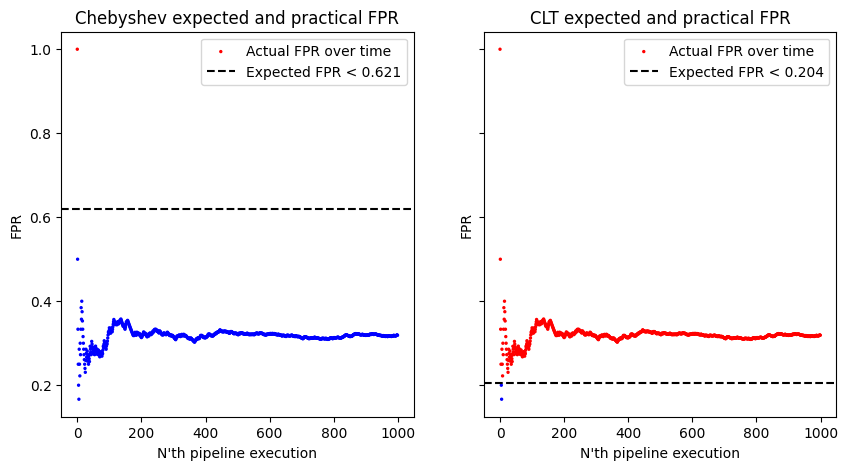

In [50]:
fig, axies = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
plot_fpr_over_time(mean_chebyshev_constraint, future_executions, axies[0])
plot_fpr_over_time(mean_clt_constraint, future_executions, axies[1])

axies[0].set_title("Chebyshev expected and practical FPR")
axies[1].set_title("CLT expected and practical FPR")

Awesome, practical simulation checks out with our expectations!  
However, if we redo the experiment a few times (i.e. fit same constraint with new historical runs and redo FPR simulations), we'll see that the constraints are not always on point and can underestimate the FPR, sometimes by a long shot!

Text(0.5, 1.0, 'CLT Constraint')

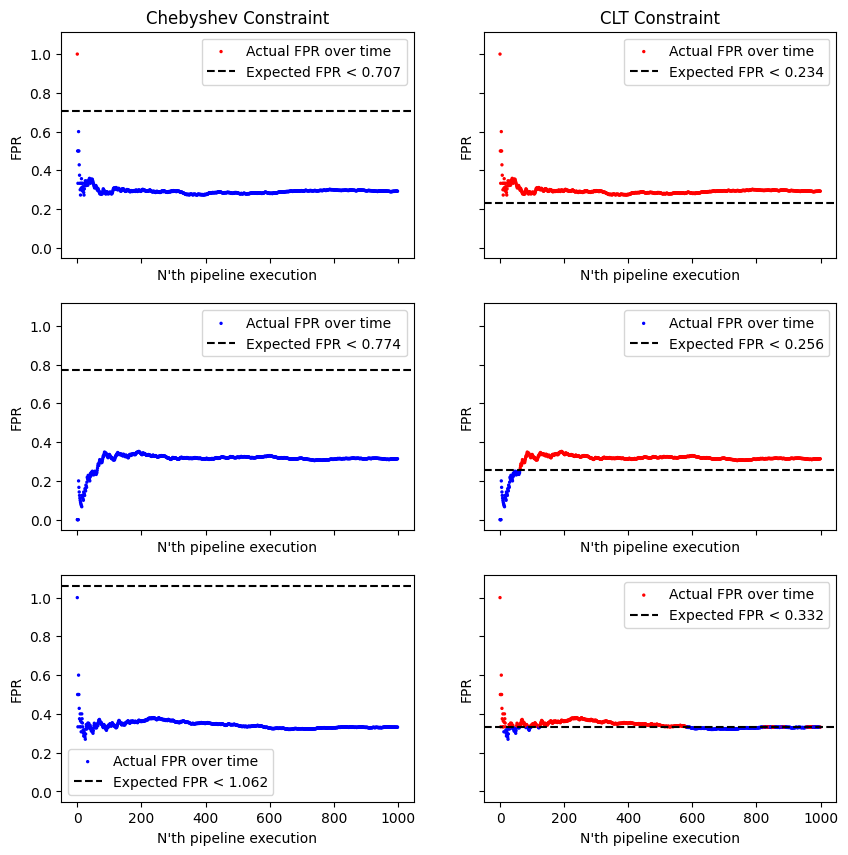

In [51]:
fig, axies = plt.subplots(3, 2, sharey=True, sharex=True, figsize=(10, 10))
for i in range(3):
    hist = [pipeline.generate(n)["money"] for i in range(pipeline_runs)]
    mean_chebyshev_constraint.fit(hist, beta=1)
    mean_clt_constraint.fit(hist, beta=1)

    futures = [pipeline.generate(n)["money"] for i in range(1000)]
    plot_fpr_over_time(mean_chebyshev_constraint, futures, axies[i][0])
    plot_fpr_over_time(mean_clt_constraint, futures, axies[i][1])

axies[0][0].set_title("Chebyshev Constraint")
axies[0][1].set_title("CLT Constraint")

As we can see both constraints can seriously underestimate their expected FPR's (when compared to theoretical bounds) and in the case of CLT-based constraint, go below practical FPR, which is really not good news!

Let's plot the distribution of our constraint expected FPR's when fitted with the same setting data:

In [52]:
mean_chebyshev_fprs = []
mean_clt_fprs = []
for i in tqdm(range(1000)):
    hist = [pipeline.generate(n)["money"] for i in range(pipeline_runs)]

    mean_chebyshev_fprs.append(
        mean_chebyshev_constraint.fit(hist, beta=1).expected_fpr_
    )
    mean_clt_fprs.append(mean_clt_constraint.fit(hist, beta=1).expected_fpr_)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 74.77it/s]


Text(0.5, 1.0, 'CLT expected FPR distribution')

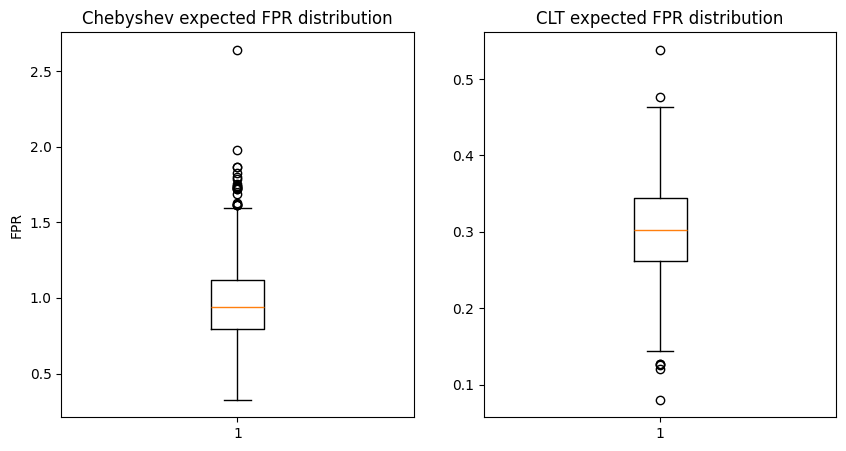

In [53]:
fig, axies = plt.subplots(1, 2, figsize=(10, 5))
axies[0].boxplot(mean_chebyshev_fprs)
axies[0].set_ylabel("FPR")
axies[0].set_title("Chebyshev expected FPR distribution")
axies[1].boxplot(mean_clt_fprs)
axies[1].set_title("CLT expected FPR distribution")

This is a bit unnerving, since while the respective distribution medians are almost right on respective theoretical FPR bounds, the lower value tails are quite fat, which means that we can seriously underestimate PFR's, thus producing constraints which are bound to do a lot of false positives.

We can try and remidy this with two main options:
* We can try and increasing our $n$ (i.e. the number of cells in our column) which should increase the precision of each estimate. Currently we have set it to be 100, but we can easily increase it, since in naturall production setting, it's not surprising to have tables with hundreds of thousands of records!
* We can increase the number of samples i.e. $H$. This should give us more reliable estimate since it would reduce the impact of random $M(C)$ variation. This, however, would be tricky to increase in production setting, as without any tricks it would mean that we'd need more DQ issue-free pipeline executions, which can be quite expensive. Furthermore, the authors in the paper seem to be using $|H|=30$ for their precision & recall experiments, so there could be more something that I didn't account for. 

Below, we visuale the effects of each change for CLT FPR estimate distributions:


In [54]:
mean_clt_fprs = {
    "n_100_h_30": [],
    "n_100_h_100": [],
    "n_1000_h_30": [],
    "n_1000_h_100": [],
}

for i in tqdm(range(1000)):
    n_100_hist = [pipeline.generate(100)["money"] for i in range(100)]
    n_10000_hist = [pipeline.generate(10000)["money"] for i in range(100)]

    n_100_h_30 = mean_clt_constraint.fit(n_100_hist[:30], beta=1).expected_fpr_
    n_100_h_100 = mean_clt_constraint.fit(n_100_hist, beta=1).expected_fpr_
    n_1000_h_30 = mean_clt_constraint.fit(n_10000_hist[:30], beta=0.1).expected_fpr_
    n_1000_h_100 = mean_clt_constraint.fit(n_10000_hist, beta=0.1).expected_fpr_

    mean_clt_fprs["n_100_h_30"].append(n_100_h_30)
    mean_clt_fprs["n_100_h_100"].append(n_100_h_100)
    mean_clt_fprs["n_1000_h_30"].append(n_1000_h_30)
    mean_clt_fprs["n_1000_h_100"].append(n_1000_h_100)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:57<00:00,  8.53it/s]


Text(0.5, 1.0, 'n=1000, |H|=100')

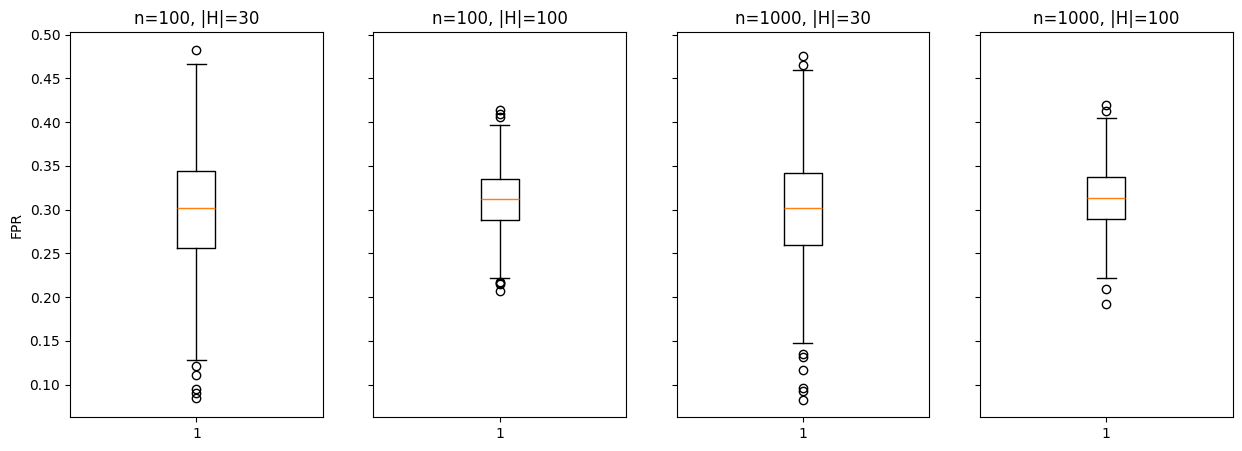

In [55]:
fig, axies = plt.subplots(1, 4, sharey=True, figsize=(15, 5))
axies[0].boxplot(mean_clt_fprs["n_100_h_30"])
axies[0].set_ylabel("FPR")
axies[0].set_title("n=100, |H|=30")
axies[1].boxplot(mean_clt_fprs["n_100_h_100"])
axies[1].set_title("n=100, |H|=100")
axies[2].boxplot(mean_clt_fprs["n_1000_h_30"])
axies[2].set_title("n=1000, |H|=30")
axies[3].boxplot(mean_clt_fprs["n_1000_h_100"])
axies[3].set_title("n=1000, |H|=100")

As we can see, adding more samples to the $H$ makes the biggest impact for getting more realistic FPR estimates. Interestingly enough, incresing the sample size doesn't make that much of a difference, possibly because the original distribution is already pretty simple and non-heavily skewed. Either way, as mentioned before $n$ is not really an issue, as it will be naturally high.

Overall, looks kinda descent

### AVH performance & sensitivy study
Let's see how our algorithm estimates FPR

In [49]:
"""
Benchmark setup

1000 Numeric columns
---
50% int
50% float

70% random normal
30% uniform

1000 Categorical columns
---
"""
p_float = 0.5
p_normal = 0.5

numeric_columns = []
for i in range(2000):
    # pick dtype
    dtype_p = np.random.random()
    column_dtype = np.float32
    if dtype_p < p_float:
        column_dtype = np.int32

    # pick generation method
    archtype_p = np.random.random()
    if archtype_p > p_normal:
        column_archtype = NormalNumericColumn
        normalised_archtype_p = (archtype_p - p_normal) / (1 - p_normal)
        loc = normalised_archtype_p * 100
        scale = max(normalised_archtype_p * 10, 0)
    else:
        column_archtype = UniformNumericColumn
        normalised_archtype_p = (archtype_p) / (p_normal)
        loc = normalised_archtype_p * 100
        scale = loc * 2

    numeric_columns.append(
        column_archtype(f"numeric_{i}", loc, scale, dtype=column_dtype)
    )

p_bounded_value_pool = 0.9

categorical_columns = []
# for i in range(1000):
#     # pick value pool
#     value_pool_p = np.random.random()
#     value_pool = None
#     if value_pool_p < p_bounded_value_pool:
#         normalised_value_pool_p = (value_pool_p) / (p_bounded_value_pool)
#         value_pool = [
#             uuid.uuid4().hex[0:6] for i in range(int(normalised_value_pool_p * 100))
#         ]

#     categorical_columns.append(RandomCategoricalColumn(f"categorical_{i}", value_pool))

pipeline = DataGenerationPipeline(columns=numeric_columns + categorical_columns)

In [50]:
%%time
test_H = []
for i in tqdm(range(60), "generating synthetic data sequences"):
    test_H.append(pipeline.generate_normal(2000, 100))

generating synthetic data sequences: 100%|███████████████████████████████████████| 60/60 [00:21<00:00,  2.74it/s]

CPU times: user 21.5 s, sys: 452 ms, total: 21.9 s
Wall time: 21.9 s


In [51]:
%%time
pipeline_ps = AVH(M, E).generate(test_H, fpr_target=0.01)

creating D(C)...: 17it [00:09,  1.75it/s]
Generating P(S for columns...: 100%|█████████████████████████████████████████| 2000/2000 [03:38<00:00,  9.14it/s]

CPU times: user 3min 47s, sys: 1.56 s, total: 3min 48s
Wall time: 3min 48s


In [52]:
%%time
pipeline_ps = AVH(M, E).generate_parallel(test_H, fpr_target=0.01)

creating D(C)...: 17it [00:09,  1.81it/s]


opa
let's go!!!


creating P(S)...: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:44<00:00, 44.76it/s]


CPU times: user 19.7 s, sys: 2.92 s, total: 22.6 s
Wall time: 55.6 s


In [49]:
pipeline_ps = AVH(M, E).generate_batched(test_H[:31], fpr_target=0.01)

creating D(C)...: 20it [00:16,  1.25it/s]
Generating Q for columns...: 100%|███████████████████████████████████████████████████████████████████| 2000/2000 [02:39<00:00, 12.54it/s]


Q generation took: 159.43340396881104


Generating P(S) for columns...: 100%|████████████████████████████████████████████████████████████████| 2000/2000 [17:32<00:00,  1.90it/s]

PS generation took: 1052.226263999939


In [50]:
# pipeline_ps = AVH(M, E).generate_batched_threaded(test_H[:31], fpr_target=0.01)

In [51]:
pipeline_ps = AVH(M, E).generate_batched_parallel(test_H[:31], fpr_target=0.01)

creating D(C)...: 20it [00:15,  1.27it/s]
Generating Q for columns...: 100%|███████████████████████████████████████████████████████████████████| 2000/2000 [00:37<00:00, 53.02it/s]


Q generation took: 38.9784300327301


Generating P(S) for columns...: 100%|████████████████████████████████████████████████████████████████| 2000/2000 [03:54<00:00,  8.54it/s]


PS generation took: 235.3743052482605


In [52]:
pipeline_ps = AVH(M, E).generate_parallel(test_H[:31], fpr_target=0.01)

creating D(C)...: 20it [00:16,  1.24it/s]


opa
let's go!!!


creating P(S)...:  86%|███████████████████████████████████████████████████████████████████           | 1720/2000 [03:37<00:35,  7.92it/s]Process SpawnPoolWorker-67:
Process SpawnPoolWorker-62:
Process SpawnPoolWorker-71:

Process SpawnPoolWorker-69:
Process SpawnPoolWorker-61:
Process SpawnPoolWorker-64:
Process SpawnPoolWorker-68:
Process SpawnPoolWorker-63:
Process SpawnPoolWorker-66:
Process SpawnPoolWorker-70:
Process SpawnPoolWorker-65:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/martynasjasinskas/.pyenv/versions/3.9.13/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/martynasjasinskas/.pyenv/versions/3.9.13/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/martynasjasinskas/.pyenv/versions/3.9.13/lib/python3.9/multiprocessing/process.py", line

In [63]:
pipeline_ps = AVH(M, E).generate(test_H[:31], fpr_target=0.01)

creating D(C)...: 17it [00:05,  3.23it/s]
Generating P(S for columns...: 100%|█████████████████████████████████████████████████████████████████| 1000/1000 [01:36<00:00, 10.35it/s]


### Time Series Differencing

The AVH algorithm and the way we construct the intervals for our metrics, expects that the $M(H)$ are "well-behaved" distribution, generated from a stationary process (static, does not change over time).

Naturally, this is unrealistic for a lot of cases. For example, let's think of a pipeline that processes each platform user record. The `RowCount` metric will keep increasing with each new execution, since the number of users keeps growing!

To address this, the authors of the paper used the technique called "time-series differencing", which simply subtracts the sequence values from the `l'th` previous entry. This, paired with the assumption that the delta between entries is somewhat constant and not completely random, should give us a desired effect of a stationary distribution.

The code excerpt below provides the implementation of this algorithm and is the exact one that `AVH` class uses under the hood.  
The steps for the algorithm are:   
1.) Iterate over possible differencing lag window values (in this case it's [1;7])  
2.) Perform Augmented Dickey-Fuller to check if our data is stationary (Return the window parameters if yes!)  
3.) If none of the differencing lag parameters managed to pass ADF test, `log()` the data and try again!  
4.) If still nothing, just ignore this `M`

In [260]:
def time_series_difference(metric_history: Iterable) -> Tuple[bool, int, Callable]:
    def is_stationary(metric_history):
        return adfuller(metric_history)[1] <= 0.05

    def search_for_stationarity(metric_history):
        for l in range(1, 8):
            metric_history_with_lag = diff(metric_history, l)[l:]
            if is_stationary(metric_history_with_lag):
                return True, l
        return False, 0

    if is_stationary(metric_history):
        return True, 0, identity

    # Perform lag transformation
    status, window = search_for_stationarity(metric_history)
    if status:
        print(f"Found stationarity with data and lag of {window}!")
        return status, window, identity

    # Perform lag transformation with log transformation
    log_metric_history = safe_log(metric_history)
    status, window = search_for_stationarity(log_metric_history)
    if status:
        print(f"Found stationarity with log(data) and lag of {window}!")
        return status, window, safe_log

    return False, 0, identity

Below, we simulate two cases where time differencing would prove useful!
One, where the increase to our column metric is monotonicly linear, and the other where it's monotonically exponential.

#### Linear increase simulation

Below we simulate a case, where a mean of normaly distributed column `money` is increased by 100 each call.

In [261]:
pipeline = DataGenerationPipeline(
    columns=[
        NormalNumericColumn(
            "money", 10, 1, parameter_function=lambda n, i, mean, std: (mean + 100, std)
        ),
    ],
)

In [262]:
H = [pipeline.generate(100)["money"] for i in range(30)]
new_c = pipeline.generate(100)["money"]

metric_history = pd.Series([Mean.calculate(run) for run in H])
std = np.std(metric_history)
print("std(M(H)) =", std)

std(M(H)) = 865.55054


Text(0.5, 1.0, 'M(H) over executions')

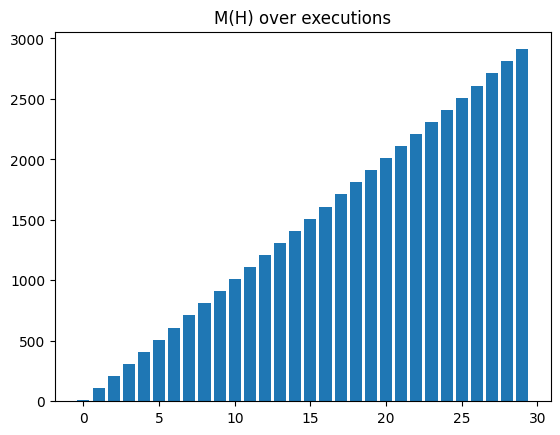

In [263]:
plt.bar(list(range(len(metric_history))), metric_history)
plt.title("M(H) over executions")

In [264]:
constraint = CLTConstraint(Mean).fit(H, beta=std)
print("fitted constraint: ", repr(constraint))

print("New execution column metric:", Mean.calculate(new_c))
print("Does C hold on Q?:", constraint.predict(new_c))

fitted constraint:  CLTConstraint(594.4312 <= Mean <= 2325.5322, FPR = 0.3173)
New execution column metric: 3009.8684
Does C hold on Q?: False


As we can already see, the next batch of data would already trigger the constraint, generating a false positive. Now, let's apply the time differencing function over the data and see if we can make it stationary-like.

In [265]:
is_stationary, lag, preprocessing_func = time_series_difference(metric_history)

Found stationarity with data and lag of 1!


Let's transform our data with the received lag parameters and plot it!

Text(0.5, 1.0, 'M(H) over executions with difference over lag = 1')

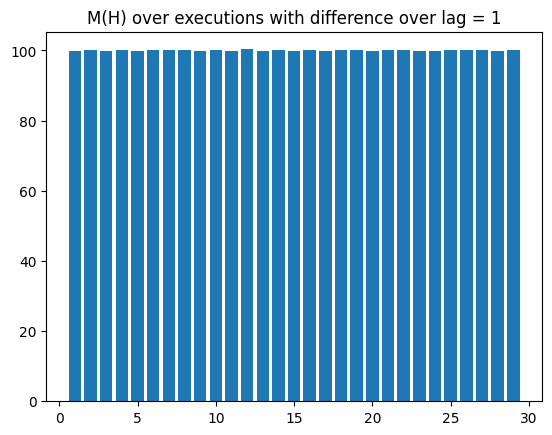

In [267]:
differenced_metric_history = diff(metric_history, lag)
plt.bar(range(len(differenced_metric_history)), differenced_metric_history)
plt.title(f"M(H) over executions with difference over lag = {lag}")

Nice! The distribution really looks static now, so we can proceed and construct our constraint with these parameters!

In [269]:
std = np.nanstd(differenced_metric_history)
constraint = CLTConstraint(Mean, differencing_lag=lag).fit(H, beta=std)
print("fitted constraint: ", repr(constraint))

new_c_metric = Mean.calculate(new_c)
new_c_metric_differenced = new_c_metric - constraint.metric_history_raw_[-1]

print("New execution column metric:", new_c_metric)
print(
    "New execution column metric (with time-series differencing):",
    new_c_metric_differenced,
)
print("Does C hold on Q?:", constraint.predict(new_c))

fitted constraint:  CLTConstraint(99.8483 <= Mean.diff(1) <= 100.1461, FPR = 0.3173)
New execution column metric: 3009.8684
New execution column metric (with time-series differencing): 99.903076
Does C hold on Q?: True


As we can see, now our C hold for the constraint! Current `Constraint` implementation stores each new $M(C)$ after `.predict()` call, so we could continue using differencing in a sequence. Technically, in actual real-world setting, we could get away by just storing the last execution value, but for EDA purposes, it's pretty neat to have the full history!

#### Exponential increase simulation

Let's do the same experiment like the above, but this time, we'll have the mean of our normal distribution increase exponentially each call

In [270]:
pipeline = DataGenerationPipeline(
    columns=[
        NormalNumericColumn(
            "money",
            2,
            0.1,
            parameter_function=lambda n, i, mean, std: (2**i, std),
        ),
    ],
)

In [271]:
H = [pipeline.generate(100)["money"] for i in range(30)]
new_c = pipeline.generate(100)["money"]

metric_history = pd.Series([Mean.calculate(run) for run in H])
std = np.std(metric_history)
print("std(M(H)) =", std)

std(M(H)) = 107374184.0


Text(0.5, 1.0, 'M(H) over executions')

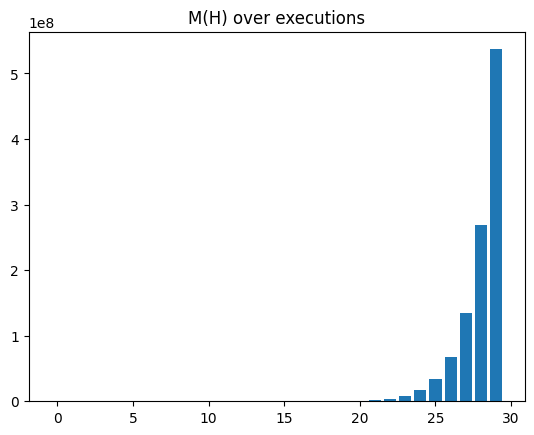

In [272]:
plt.bar(list(range(len(metric_history))), metric_history)
plt.title("M(H) over executions")

In [273]:
constraint = CLTConstraint(Mean).fit(H, beta=std)
print("fitted constraint: ", repr(constraint))

print("New execution column metric:", Mean.calculate(new_c))
print("Does C hold on Q?:", constraint.predict(new_c))

fitted constraint:  CLTConstraint(-71582784.0000 <= Mean <= 143165584.0000, FPR = 0.3173)
New execution column metric: 1073741800.0
Does C hold on Q?: False


In [280]:
is_stationary, lag, preprocessing_func = time_series_difference(metric_history)

Found stationarity with log(data) and lag of 1!


This time around, the we achieved stationarity only when applying `log()` to our data. Let's see it in action!

Text(0.5, 1.0, 'log(M(H)) over executions')

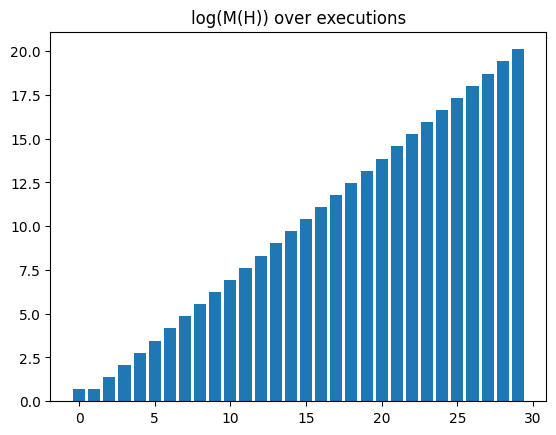

In [281]:
log_metric_history = preprocessing_func(metric_history)

plt.bar(range(len(log_metric_history)), log_metric_history)
plt.title(f"log(M(H)) over executions")

Yep, `log()` did the trick, since even differencing with lag of 1, will be able to make this distribution stationary

Text(0.5, 1.0, 'log(M(H)) over executions with difference over lag = 1')

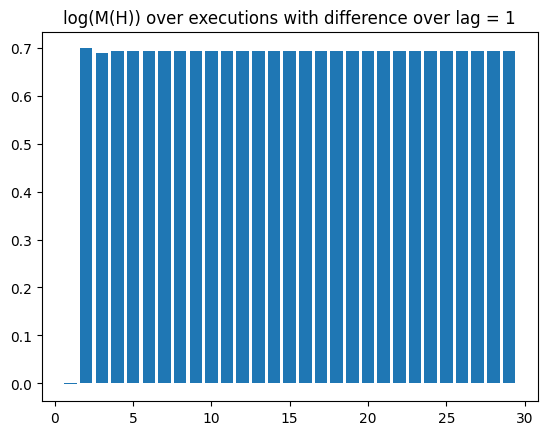

In [283]:
differenced_metric_history = diff(log_metric_history, lag)

plt.bar(range(len(differenced_metric_history)), differenced_metric_history)
plt.title(f"log(M(H)) over executions with difference over lag = {lag}")

In [285]:
std = np.nanstd(differenced_metric_history)
constraint = CLTConstraint(
    Mean, differencing_lag=lag, preprocessing_func=preprocessing_func
).fit(H, beta=std)
print("fitted constraint: ", repr(constraint))

new_c_metric = Mean.calculate(new_c)
new_c_log_metric = preprocessing_func(new_c_metric)
new_c_metric_differenced = new_c_log_metric - preprocessing_func(
    constraint.metric_history_raw_[-1]
)

print("New execution column metric:", new_c_metric)
print(
    "New execution column metric (with time-series differencing):",
    round(new_c_metric_differenced, 4),
)
print("Does C hold on Q?:", constraint.predict(new_c))

fitted constraint:  CLTConstraint(0.5423 <= log(Mean).diff(1) <= 0.7962, FPR = 0.3173)
New execution column metric: 1073741800.0
New execution column metric (with time-series differencing): 0.6931
Does C hold on Q?: True


Amazing, looks like our time series differencing and preprocessing function integration seems to be working nicely with our constraints!

P.S. Even though I've presented some positive examples in this differencing section, in my development experiments, I have noticed, that ADF is really not a magical test, since for a lot of cases, ADF seemed to "miss" lag options that would create actual stationary series. For example, if we were to create a series, where the increment only happens every 3'rd time step, the natural lag window would be 3, however, ADF would only reject $H_0$ for lag window of 4... Reading online, it seems that such stationarity test are notorous for having lower statistical power... Thus, I think it would be wise to allow the user to specify the actual lag for the constraints if they know their data well and not relly on ADF (e.g. if they know that their data is cyclic with a weekly trend, then simply input the lag window of 7).